In [10]:
import re
import string
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, Bidirectional

In [11]:
# Text preprocessing function
def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text

str_punc = string.punctuation.replace(',', '').replace("'",'')

In [12]:
# Read dataset & Preprocess text
dataset = pd.read_csv('/content/drive/MyDrive/Dataset Capstone/dataset.csv')

X = dataset['Sentence'].apply(clean)
y = dataset['Type']

<Axes: >

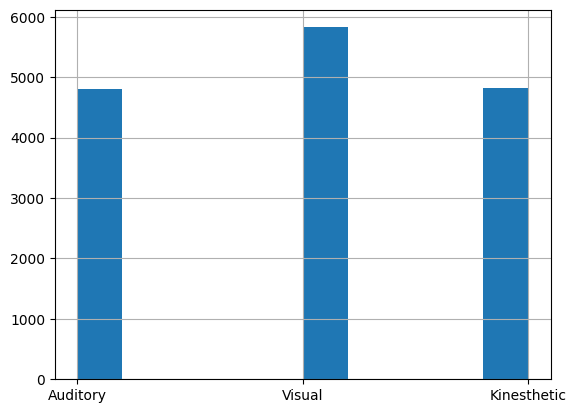

In [13]:
# Visualize classes counts
dataset['Type'].hist()

In [14]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)


text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_test = tokenizer.texts_to_sequences(text_test)
X_train = pad_sequences(sequences_train, maxlen=48, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=48, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary Size = {vocabSize}")

Vocabulary Size = 26862


In [15]:
# Read GloVE embeddings

path_to_glove_file = '/content/drive/MyDrive/Dataset Capstone/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 23821 words (3040 misses)


In [16]:
# Build neural network architecture

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128, dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 200)           5372400   
                                                                 
 lstm (LSTM)                 (None, 48, 256)           467968    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 6037875 (23.03 MB)
Trainable params: 665475 (2.54 MB)
Non-trainable params: 5372400 (20.49 MB)
_________________________________________________________________


In [17]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=64,
                    epochs=10)

Epoch 1/10
194/194 [==============================] - 121s 542ms/step - loss: 0.7233 - accuracy: 0.6788 - val_loss: 0.5407 - val_accuracy: 0.7909
Epoch 2/10
194/194 [==============================] - 97s 500ms/step - loss: 0.4239 - accuracy: 0.8320 - val_loss: 0.2873 - val_accuracy: 0.8890
Epoch 3/10
194/194 [==============================] - 100s 515ms/step - loss: 0.2321 - accuracy: 0.9090 - val_loss: 0.1976 - val_accuracy: 0.9220
Epoch 4/10
194/194 [==============================] - 97s 498ms/step - loss: 0.1629 - accuracy: 0.9334 - val_loss: 0.1557 - val_accuracy: 0.9346
Epoch 5/10
194/194 [==============================] - 99s 507ms/step - loss: 0.1203 - accuracy: 0.9443 - val_loss: 0.1375 - val_accuracy: 0.9382
Epoch 6/10
194/194 [==============================] - 96s 495ms/step - loss: 0.1073 - accuracy: 0.9492 - val_loss: 0.1298 - val_accuracy: 0.9440
Epoch 7/10
194/194 [==============================] - 101s 522ms/step - loss: 0.0952 - accuracy: 0.9545 - val_loss: 0.1316 - val

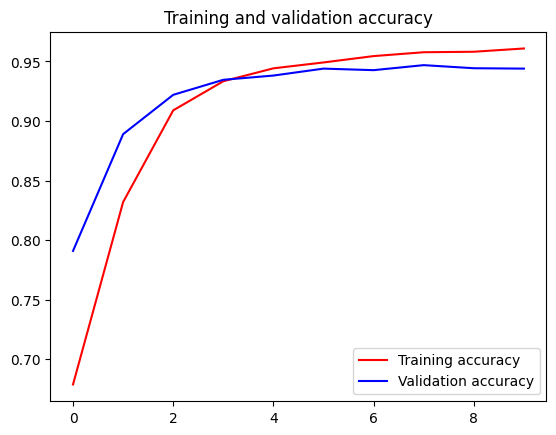

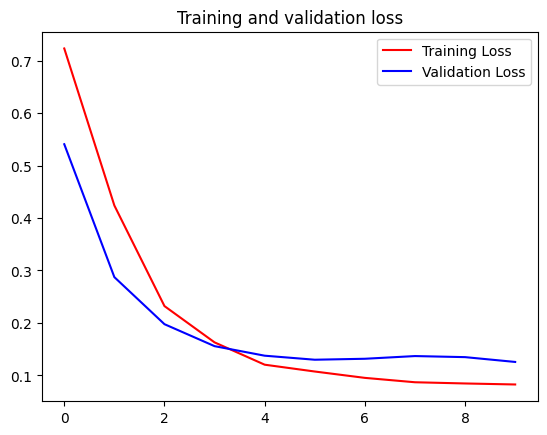

In [18]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
model.evaluate(X_test, y_test, verbose=1)

97/97 [==============================] - 5s 49ms/step - loss: 0.1256 - accuracy: 0.9440


[0.12558116018772125, 0.9440129399299622]

In [20]:
# Classify custom sample

sentences = ["Can you imagine how this idea's gonna change the education system!", # Visual
             "Brilliant! I can't wait to hear the news about this change!", # Auditory
             "Chill out guys, nothing's gonna change, we have to study hard to succeed" # Kinesthetic
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=48, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

Can you imagine how this idea's gonna change the education system!
1/1 [==============================] - 0s 177ms/step
Visual : 0.9980323910713196


Brilliant! I can't wait to hear the news about this change!
1/1 [==============================] - 0s 320ms/step
Auditory : 0.9965583682060242


Chill out guys, nothing's gonna change, we have to study hard to succeed
1/1 [==============================] - 0s 61ms/step
Kinesthetic : 0.9962575435638428


